# Hidden tertiaries

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split

from binaryStatistics.base_distribution import BaseDistribution
from binaryStatistics.distributions import Uniform, Thermal, PowerLaw, Sine, VelTilde, PhiAngle, Log
from binaryStatistics.plot_utils import plot_histogram

In [2]:
def get_companions_mass(Mag1, Mag2, label="without"):
    
    def get_kappa(delta_Mag):
        dM = delta_Mag.random_sample(0.01,12,1)
        return 1/(1 + 10**(-0.4*dM))[0]
    
    def get_mass(mag):
        return 10**(0.0725*(4.76 - mag))
    
    gamma = -0.7
    delta_Mag = PowerLaw(
        dist_parameters={
            "C": (1 + gamma)/(12**gamma),
            "alpha": gamma,
        }
    )
    kappa = get_kappa(delta_Mag)
    
    if label == "without":
        return {
            "mass_A_1": get_mass(Mag1),
            "mass_A_2": 0.0,
            "mass_B_1": get_mass(Mag2),
            "mass_B_2": 0.0,
        }
    elif label == "more":
        if Mag1 > Mag2:
            host = -2.5*np.log10(kappa) + Mag1
            comp = -2.5*np.log10(1 - kappa) + Mag1
            
            return {
                "mass_A_1": get_mass(host),
                "mass_A_2": get_mass(comp),
                "mass_B_1": get_mass(Mag2),
                "mass_B_2": 0.0,
            }
        else:
            host = -2.5*np.log10(kappa) + Mag2
            comp = -2.5*np.log10(1 - kappa) + Mag2
            
            return {
                "mass_A_1": get_mass(Mag1),
                "mass_A_2": 0.0,
                "mass_B_1": get_mass(host),
                "mass_B_2": get_mass(comp),
            }
            
    elif label == "less":
        if Mag1 < Mag2:
            host = -2.5*np.log10(kappa) + Mag1
            comp = -2.5*np.log10(1 - kappa) + Mag1
            
            return {
                "mass_A_1": get_mass(host),
                "mass_A_2": get_mass(comp),
                "mass_B_1": get_mass(Mag2),
                "mass_B_2": 0.0,
            }
        else:
            host = -2.5*np.log10(kappa) + Mag2
            comp = -2.5*np.log10(1 - kappa) + Mag2
            
            return {
                "mass_A_1": get_mass(Mag2),
                "mass_A_2": 0.0,
                "mass_B_1": get_mass(host),
                "mass_B_2": get_mass(comp),
            }
        
    elif label == "both":
        kappa = get_kappa(delta_Mag)
        host_1 = -2.5*np.log10(kappa) + Mag1
        comp_1 = -2.5*np.log10(1 - kappa) + Mag1
        kappa = get_kappa(delta_Mag)
        host_2 = -2.5*np.log10(kappa) + Mag2
        comp_2 = -2.5*np.log10(1 - kappa) + Mag2
        
        return {
            "mass_A_1": get_mass(host_1),
            "mass_A_2": get_mass(comp_1),
            "mass_B_1": get_mass(host_2),
            "mass_B_2": get_mass(comp_2),
        }

In [3]:
## With this line we extract all the data in the file WB450.csv
binary_dataframe = pd.read_csv("../data/667Bp_0.8.csv")

In [4]:
binary_dataframe.head()

,Unnamed: 0,SOURCE_ID_PRIMARY,ra1,dec1,mag1,MAG1,PARALLAX1,parallax_error1,DIST1,RUWE1,...,vRA,vRAerr,vDEC,vDECerr,V2D,Log10vRA,Log10vDEC,Log10r,r,M
0,0,4.892827e+16,62.659863,20.039590,8.637080,8.637080,19.120252,0.016533,52.300567,1.149334,...,1.414944,0.027036,1.007481,"(0.10233914394539495,)",1.736976,0.150739,0.003237,-3.054217,0.000883,1.140540
1,1,5.372056e+16,62.352435,23.464026,7.798275,7.798275,14.891271,0.019507,67.153435,1.070155,...,0.882973,0.072469,1.382309,"(0.06742163043034524,)",1.640250,-0.054053,0.140605,-2.813512,0.001536,1.258145
2,2,7.716122e+16,32.717524,13.682958,4.862433,4.862433,23.304385,0.028325,42.910379,1.113712,...,0.609415,0.065854,0.283278,"(0.04558037119673894,)",0.672036,-0.215087,-0.547788,-2.902558,0.001252,1.844137
3,3,1.049989e+17,28.829107,24.292369,7.350453,7.350453,16.623353,0.017599,60.156335,0.883072,...,0.206057,0.057484,0.092202,"(0.05333571922184351,)",0.225745,-0.686012,-1.035257,-1.488954,0.032437,1.387181
4,4,9.869261e+16,29.196527,23.051061,5.024877,5.024877,29.509924,0.022391,33.886906,0.915890,...,0.337392,0.027361,0.257691,"(0.011056875463707696,)",0.424545,-0.471865,-0.588901,-2.012038,0.009727,1.529926


1. Split the CSV dataset into a 40\% with companion(s) and 60\% without companion(s)

In [142]:
f = 0.8
bd_without_comp, bd_with_comp = train_test_split(binary_dataframe, test_size=f, train_size=1-f)

2. The 40\% with companion is splitted into 30\% binaries where both components have hidden companions, and 70\% where only one does. 

In [143]:
bd_with_comp_one, bd_with_comp_both = train_test_split(bd_with_comp, test_size=0.3, train_size=0.7)

3. Finally, this remaining 70\% is splitted into a 30\% where the companion is in the component with less luminosity, and 40\% where the companion is in the component of greater luminosity.

In [144]:
bd_with_comp_more, bd_with_comp_less = train_test_split(bd_with_comp_one, test_size=0.3/0.7, train_size=0.4/0.7)

4. Using Pandas' apply method, we can apply the `get_companions_mass` functions to obtain the new columns `mass_comp_1` and `mass_comp_2`. This columns contain the mass of the component (1 and 2) plus the mass of the hidden companion, if it is the case. 

In [145]:
bd_without_comp[["mass_A_1","mass_A_2","mass_B_1","mass_B_2"]] = bd_without_comp.apply(lambda x: get_companions_mass(x.MAG1, x.MAG2, label="without"), axis=1, result_type='expand')
bd_with_comp_both[["mass_A_1","mass_A_2","mass_B_1","mass_B_2"]] = bd_with_comp_both.apply(lambda x: get_companions_mass(x.MAG1, x.MAG2, label="both"), axis=1, result_type='expand')
bd_with_comp_more[["mass_A_1","mass_A_2","mass_B_1","mass_B_2"]] = bd_with_comp_more.apply(lambda x: get_companions_mass(x.MAG1, x.MAG2, label="more"), axis=1, result_type='expand')
bd_with_comp_less[["mass_A_1","mass_A_2","mass_B_1","mass_B_2"]] = bd_with_comp_less.apply(lambda x: get_companions_mass(x.MAG1, x.MAG2, label="less"), axis=1, result_type='expand')

In [146]:
new_binary_dataframe = pd.concat([bd_without_comp, bd_with_comp_both, bd_with_comp_more, bd_with_comp_less])
new_binary_dataframe["M_A"] = new_binary_dataframe["mass_A_1"] + new_binary_dataframe["mass_A_2"]
new_binary_dataframe["M_B"] = new_binary_dataframe["mass_B_1"] + new_binary_dataframe["mass_B_2"]
new_binary_dataframe["M_modif"] = new_binary_dataframe["mass_A_1"] + new_binary_dataframe["mass_A_2"] + new_binary_dataframe["mass_B_1"] + new_binary_dataframe["mass_B_2"]

In [147]:
binary_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667 entries, 0 to 666
Data columns (total 58 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           667 non-null    int64  
 1   SOURCE_ID_PRIMARY    667 non-null    float64
 2   ra1                  667 non-null    float64
 3   dec1                 667 non-null    float64
 4   mag1                 667 non-null    float64
 5   MAG1                 667 non-null    float64
 6   PARALLAX1            667 non-null    float64
 7   parallax_error1      667 non-null    float64
 8   DIST1                667 non-null    float64
 9   RUWE1                667 non-null    float64
 10  PMRA1                667 non-null    float64
 11  PMRA_ERROR1          667 non-null    float64
 12  PMDEC1               667 non-null    float64
 13  PMDEC_ERROR1         667 non-null    float64
 14  BminusR1             667 non-null    float64
 15  mass_calc1           667 non-null    flo

In [148]:
new_binary_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 667 entries, 466 to 150
Data columns (total 65 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           667 non-null    int64  
 1   SOURCE_ID_PRIMARY    667 non-null    float64
 2   ra1                  667 non-null    float64
 3   dec1                 667 non-null    float64
 4   mag1                 667 non-null    float64
 5   MAG1                 667 non-null    float64
 6   PARALLAX1            667 non-null    float64
 7   parallax_error1      667 non-null    float64
 8   DIST1                667 non-null    float64
 9   RUWE1                667 non-null    float64
 10  PMRA1                667 non-null    float64
 11  PMRA_ERROR1          667 non-null    float64
 12  PMDEC1               667 non-null    float64
 13  PMDEC_ERROR1         667 non-null    float64
 14  BminusR1             667 non-null    float64
 15  mass_calc1           667 non-null    float6

Text(0, 0.5, 'Mass with hidden tertiaries ($M_\\odot$)')

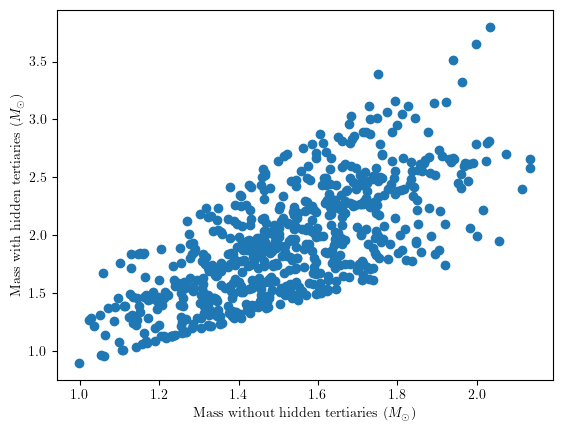

In [149]:
plt.scatter(new_binary_dataframe["M"], new_binary_dataframe["M_modif"])
plt.xlabel(r"Mass without hidden tertiaries ($M_\odot$)")
plt.ylabel(r"Mass with hidden tertiaries ($M_\odot$)")

In [150]:
thermal = Thermal()
new_binary_dataframe["eccentricity"] = new_binary_dataframe["M"].apply(lambda x: thermal.random_sample(0,1,size=1)[0])

In [151]:
sine = Sine()
new_binary_dataframe["i_angle"] = new_binary_dataframe["M"].apply(lambda x: sine.random_sample(0,np.pi/2,size=1)[0])

In [152]:
uniform = Uniform()
new_binary_dataframe["phi_0"] = new_binary_dataframe["M"].apply(lambda x: uniform.random_sample(0,2*np.pi,size=1)[0])

In [153]:
def phi_angle(e):
    phi = PhiAngle(
        dist_parameters={
            "e": e,
        }
    )
    return phi.random_sample(0,2*np.pi, size=1)[0]
new_binary_dataframe["phi"] = new_binary_dataframe["eccentricity"].apply(lambda x: phi_angle([x]))

In [154]:
new_binary_dataframe["r_3D"] = new_binary_dataframe.apply(lambda x: x.r/np.sqrt(np.cos(x.phi)**2 + (np.sin(x.phi)**2)*np.cos(x.i_angle)**2), axis=1)

In [155]:
new_binary_dataframe["a"] = new_binary_dataframe.apply(lambda x: x.r_3D*(1 + x.eccentricity*np.cos(x.phi - x.phi_0))/(1 - x.eccentricity**2), axis=1)

In [156]:
v_tilde = VelTilde()
new_binary_dataframe["v_tilde"] = new_binary_dataframe.apply(lambda x: v_tilde.distribution(x.phi, x.phi_0, x.i_angle, x.eccentricity), axis=1)

In [157]:
G = 4.3009e-03 # pc·(km/s)²·M_\odot⁻¹
new_binary_dataframe["v2Dp_notert"] = new_binary_dataframe.apply(lambda x: np.sqrt(G*x.M/x.r)*x.v_tilde, axis=1)
new_binary_dataframe["v2Dp_tert"] = new_binary_dataframe.apply(lambda x: np.sqrt(G*x.M_modif/x.r)*x.v_tilde, axis=1)

In [158]:
new_binary_dataframe["psi"] = new_binary_dataframe.apply(lambda x: np.arctan(-(np.cos(x.phi) + x.eccentricity*np.cos(x.phi_0))/(np.sin(x.phi) + x.eccentricity*np.sin(x.phi_0))), axis=1)

In [159]:
new_binary_dataframe["v3D_notert"] = new_binary_dataframe.apply(lambda x: x.v2Dp_notert/np.sqrt(np.cos(x.psi)**2 + (np.cos(x.i_angle)**2)*(np.sin(x.psi)**2)), axis=1)
new_binary_dataframe["v3D_tert"] = new_binary_dataframe.apply(lambda x: x.v2Dp_tert/np.sqrt(np.cos(x.psi)**2 + (np.cos(x.i_angle)**2)*(np.sin(x.psi)**2)), axis=1)

In [160]:
new_binary_dataframe["vp_x"] = new_binary_dataframe.apply(lambda x: -x.v3D_tert*np.sin(x.phi), axis=1)
new_binary_dataframe["vp_y"] = new_binary_dataframe.apply(lambda x: x.v3D_tert*np.cos(x.phi), axis=1)

In [161]:
new_binary_dataframe["delta_l"] = new_binary_dataframe.apply(lambda x: x.r_3D * np.sin(x.i_angle) * np.sin(x.phi), axis=1)

Text(0, 0.5, '2D relative velocity (km/s)')

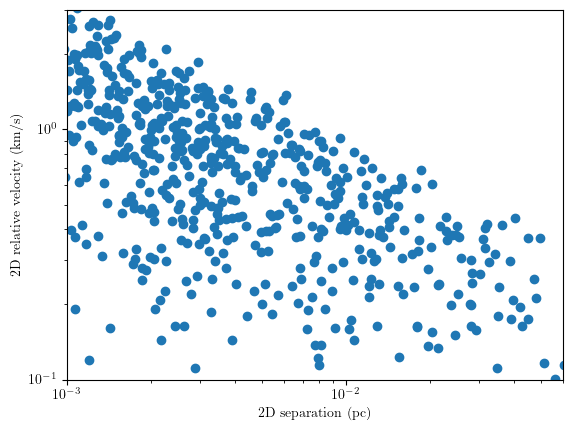

In [162]:
fig, ax = plt.subplots()
ax.scatter(new_binary_dataframe["r"],new_binary_dataframe["v2Dp_notert"])
plt.xscale("log")
plt.yscale("log")
ax.set_xlim(0.001,0.06)
ax.set_ylim(0.1,3)
ax.set_xlabel("2D separation (pc)")
ax.set_ylabel("2D relative velocity (km/s)")

Text(0, 0.5, '2D relative velocity (km/s)')

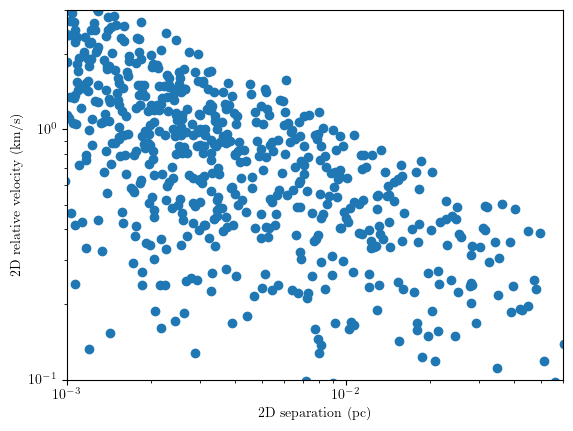

In [163]:
fig, ax = plt.subplots()
ax.scatter(new_binary_dataframe["r"],new_binary_dataframe["v2Dp_tert"])
plt.xscale("log")
plt.yscale("log")
ax.set_xlim(0.001,0.06)
ax.set_ylim(0.1,3)
ax.set_xlabel("2D separation (pc)")
ax.set_ylabel("2D relative velocity (km/s)")

In [164]:
thermal = Thermal()
new_binary_dataframe["eccentricity_A"] = new_binary_dataframe["M"].apply(lambda x: thermal.random_sample(0,1,size=1)[0])
new_binary_dataframe["eccentricity_B"] = new_binary_dataframe["M"].apply(lambda x: thermal.random_sample(0,1,size=1)[0])

In [165]:
sine = Sine()
new_binary_dataframe["i_angle_A"] = new_binary_dataframe["M"].apply(lambda x: sine.random_sample(0,np.pi/2,size=1)[0])
new_binary_dataframe["i_angle_B"] = new_binary_dataframe["M"].apply(lambda x: sine.random_sample(0,np.pi/2,size=1)[0])

In [166]:
uniform = Uniform()
new_binary_dataframe["phi_0_A"] = new_binary_dataframe["M"].apply(lambda x: uniform.random_sample(0,2*np.pi,size=1)[0])
new_binary_dataframe["phi_0_B"] = new_binary_dataframe["M"].apply(lambda x: uniform.random_sample(0,2*np.pi,size=1)[0])

In [167]:
def phi_angle(e):
    phi = PhiAngle(
        dist_parameters={
            "e": e,
        }
    )
    return phi.random_sample(0,2*np.pi, size=1)[0]
new_binary_dataframe["phi_A"] = new_binary_dataframe["eccentricity_A"].apply(lambda x: phi_angle([x]))
new_binary_dataframe["phi_B"] = new_binary_dataframe["eccentricity_B"].apply(lambda x: phi_angle([x]))

In [168]:
log = Log()
new_binary_dataframe["a_in_A"] = new_binary_dataframe.apply(lambda x: log.random_sample(0.01, x.PARALLAX1, size=1)[0], axis=1)
new_binary_dataframe["a_in_B"] = new_binary_dataframe.apply(lambda x: log.random_sample(0.01, x.PARALLAX2, size=1)[0], axis=1)

In [169]:
new_binary_dataframe["r_3D_in_A"] = new_binary_dataframe.apply(lambda x: x.a_in_A*(1 - x.eccentricity_A**2)/(1 + x.eccentricity_A*np.cos(x.phi_A - x.phi_0_A)), axis=1)
new_binary_dataframe["r_3D_in_B"] = new_binary_dataframe.apply(lambda x: x.a_in_B*(1 - x.eccentricity_B**2)/(1 + x.eccentricity_B*np.cos(x.phi_B - x.phi_0_B)), axis=1)

In [170]:
new_binary_dataframe["eta_phot_A"] = new_binary_dataframe.apply(lambda x: x.mass_A_2/(x.M_A), axis=1)
new_binary_dataframe["eta_phot_B"] = new_binary_dataframe.apply(lambda x: x.mass_B_2/(x.M_B), axis=1)

In [171]:
v_tilde = VelTilde()
new_binary_dataframe["v_tilde_A"] = new_binary_dataframe.apply(lambda x: v_tilde.distribution(x.phi_A, x.phi_0_A, x.i_angle_A, x.eccentricity_A), axis=1)
new_binary_dataframe["v_tilde_B"] = new_binary_dataframe.apply(lambda x: v_tilde.distribution(x.phi_B, x.phi_0_B, x.i_angle_B, x.eccentricity_B), axis=1)

In [172]:
new_binary_dataframe["s_A"] = new_binary_dataframe.apply(lambda x: x.r_3D_in_A*np.sqrt(np.cos(x.phi_A)**2 + (np.sin(x.phi_A)**2)*np.cos(x.i_angle_A)**2), axis=1)
new_binary_dataframe["s_B"] = new_binary_dataframe.apply(lambda x: x.r_3D_in_B*np.sqrt(np.cos(x.phi_B)**2 + (np.sin(x.phi_B)**2)*np.cos(x.i_angle_B)**2), axis=1)

In [173]:
G = 4.3009e-03 # pc·(km/s)²·M_\odot⁻¹
new_binary_dataframe["v2Dp_A"] = new_binary_dataframe.apply(lambda x: x.eta_phot_A*np.sqrt(G*x.M_A/x.s_A)*x.v_tilde_A, axis=1)
new_binary_dataframe["v2Dp_B"] = new_binary_dataframe.apply(lambda x: x.eta_phot_B*np.sqrt(G*x.M_B/x.s_B)*x.v_tilde_B, axis=1)

In [174]:
new_binary_dataframe["psi_A"] = new_binary_dataframe.apply(lambda x: np.arctan(-(np.cos(x.phi_A) + x.eccentricity_A*np.cos(x.phi_0_A))/(np.sin(x.phi_A) + x.eccentricity_A*np.sin(x.phi_0_A))), axis=1)
new_binary_dataframe["psi_B"] = new_binary_dataframe.apply(lambda x: np.arctan(-(np.cos(x.phi_B) + x.eccentricity_B*np.cos(x.phi_0_B))/(np.sin(x.phi_B) + x.eccentricity_B*np.sin(x.phi_0_B))), axis=1)

In [175]:
new_binary_dataframe["v3D_A"] = new_binary_dataframe.apply(lambda x: x.v2Dp_A/np.sqrt(np.cos(x.psi_A)**2 + (np.cos(x.i_angle_A)**2)*(np.sin(x.psi_B)**2)), axis=1)
new_binary_dataframe["v3D_B"] = new_binary_dataframe.apply(lambda x: x.v2Dp_B/np.sqrt(np.cos(x.psi_B)**2 + (np.cos(x.i_angle_B)**2)*(np.sin(x.psi_B)**2)), axis=1)

In [176]:
new_binary_dataframe["vp_A_x"] = new_binary_dataframe.apply(lambda x: -x.v3D_A*np.sin(x.phi_A), axis=1)
new_binary_dataframe["vp_A_y"] = new_binary_dataframe.apply(lambda x: x.v3D_A*np.cos(x.phi_A), axis=1)

In [177]:
new_binary_dataframe["vp_B_x"] = new_binary_dataframe.apply(lambda x: -x.v3D_B*np.sin(x.phi_B), axis=1)
new_binary_dataframe["vp_B_y"] = new_binary_dataframe.apply(lambda x: x.v3D_B*np.cos(x.phi_B), axis=1)

In [178]:
new_binary_dataframe["vp_X"] = new_binary_dataframe.apply(lambda x: x.vp_x + x.vp_A_x*x.eta_phot_A + x.vp_B_x*x.eta_phot_B, axis=1)
new_binary_dataframe["vp_Y"] = new_binary_dataframe.apply(lambda x: x.vp_y + x.vp_A_y*x.eta_phot_A + x.vp_B_y*x.eta_phot_B, axis=1)

In [179]:
new_binary_dataframe["v2D_tertiaries"] = new_binary_dataframe.apply(lambda x: np.sqrt(x.vp_X**2 + x.vp_Y**2), axis=1)

(0.1, 3)

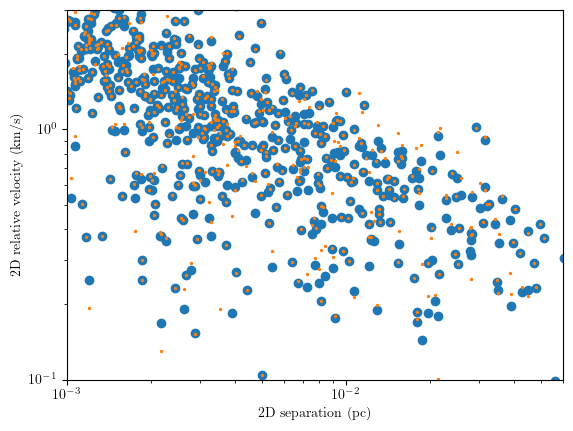

In [180]:
fig, ax = plt.subplots()
ax.scatter(new_binary_dataframe["r"],np.sqrt(new_binary_dataframe["vp_x"]**2 + new_binary_dataframe["vp_y"]**2))
ax.scatter(new_binary_dataframe["r"],new_binary_dataframe["v2D_tertiaries"], s=2)
plt.xscale("log")
plt.yscale("log")
ax.set_xlabel("2D separation (pc)")
ax.set_ylabel("2D relative velocity (km/s)")
ax.set_xlim(0.001,6e-2)
ax.set_ylim(0.1,3)

In [181]:
plt.scatter??

Signature:
plt.scatter(
    x,
    y,
    s=None,
    c=None,
    marker=None,
    cmap=None,
    norm=None,
    vmin=None,
    vmax=None,
    alpha=None,
    linewidths=None,
    *,
    edgecolors=None,
    plotnonfinite=False,
    data=None,
    **kwargs,
)
Docstring:
A scatter plot of *y* vs. *x* with varying marker size and/or color.

Parameters
----------
x, y : float or array-like, shape (n, )
    The data positions.

s : float or array-like, shape (n, ), optional
    The marker size in points**2.
    Default is ``rcParams['lines.markersize'] ** 2``.

c : array-like or list of colors or color, optional
    The marker colors. Possible values:

    - A scalar or sequence of n numbers to be mapped to colors using
      *cmap* and *norm*.
    - A 2D array in which the rows are RGB or RGBA.
    - A sequence of colors of length n.
    - A single color format string.

    Note that *c* should not be a single numeric RGB or RGBA sequence
    because that is indistinguishable from an arra